# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. We start with a simple model here:

\begin{align}
\tau^2 & \sim P(\cdot) \\
\gamma_g &  \sim \mathcal{N}(0, \tau^2) \\
\beta_{cg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{cg} & \sim \text{Log-Norm}(0, 1) \\
\alpha & \propto 1 \\
x_{cgs} \mid \beta_{cg} &  \sim \text{Pois}\left(l_{cgs} \cdot \exp \left(\alpha +  \beta_{cg} \right) \right) \\
\end{align}

In [74]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy as sp
import theano.tensor as tt

In [3]:
from sklearn import preprocessing
from pymc3 import  model_to_graphviz

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

## Simulated data

In [6]:
seed = 42
np.random.seed(seed)

In [7]:
conditions = ["C" + str(i) for i in range(3)]
genes = ["G" + str(i) for i in range(3)]
sgrnas = ["S" + str(i) for i in range(3)]
replicates = ["R" + str(i) for i in range(5)]

In [8]:
combinations = [(c, g, s, r) \
     for c in conditions for g in genes \
     for s in sgrnas for r in replicates]

In [9]:
count_table = pd.DataFrame(
    combinations, 
    columns=["conditions", "genes", "sgrnas", "replicates"])

In [10]:
tau_true = sp.stats.halfcauchy.rvs(0, 3, size=1)

In [11]:
gamma_true = sp.stats.norm.rvs(0, tau_true, size=len(genes))

In [12]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, len(conditions)), tau_true)
beta_true = np.repeat(beta_true, len(sgrnas) * len((replicates)))

In [13]:
l_true = sp.stats.lognorm.rvs(
    1, size= len(conditions) * len(genes) * len(sgrnas))
l_true = np.repeat(l_true, len(replicates))

In [14]:
alpha_true = sp.stats.uniform.rvs(0, 20)
alpha_true

In [16]:
le = preprocessing.LabelEncoder()
for i in count_table.columns.values:
    count_table[i] = le.fit_transform(count_table[i])

Below we test some models. 

In [26]:
count_table["counts"] = sp.stats.poisson.rvs(
    l_true * np.exp(alpha_true + beta_true))

Let's start with a simple one.

In [79]:
 gamma_true = sp.stats.norm.rvs(0, tau_true, size=count_table.shape[0])

In [80]:
count_table["counts"] = sp.stats.poisson.rvs(
    np.exp(alpha_true + gamma_true)
)

In [81]:
count_table[:10]

,conditions,genes,sgrnas,replicates,counts
0,0,0,0,0,163
1,0,0,0,1,1
2,0,0,0,2,32
3,0,0,0,3,7
4,0,0,0,4,550
5,0,0,1,0,209
6,0,0,1,1,380
7,0,0,1,2,4
8,0,0,1,3,238
9,0,0,1,4,47


## Inference

In [31]:
conditions_idx = np.repeat(range(len(genes)), len(conditions))
alpha_idx = np.array([0] * count_table.shape[0])
beta_idx = np.repeat(range(len(genes) * len(conditions)), len(sgrnas) * len(replicates))
l_idx = np.repeat(range(len(genes) * len(conditions) * len(sgrnas)), len(replicates))
l_shape =  len(genes) * len(conditions) * len(sgrnas)
tau_b_idx = np.array([0] * len(genes) * len(conditions))

In [89]:
with pm.Model() as model:
    tau_g = pm.HalfCauchy('tau_g', 1., shape=1)
    gamma = pm.Normal('gamma', 0., tau_g, shape=count_table.shape[0])
    #tau_b = pm.HalfCauchy('tau_b', 1., shape=1)
    #beta = pm.Normal('beta', gamma[conditions_idx], tau_b[tau_b_idx], shape=9)
    #l = pm.Lognormal('l', 1, 1, shape=l_shape)
    alpha = pm.Uniform('alpha', 0, 20, shape=1)
    x = pm.Poisson(
        'x', 
        #mu = l[l_idx] * np.exp(alpha[alpha_idx] + np.exp(beta[beta_idx])),            
        mu = np.exp(alpha[alpha_idx] + gamma),            
        observed=count_table["counts"].values)

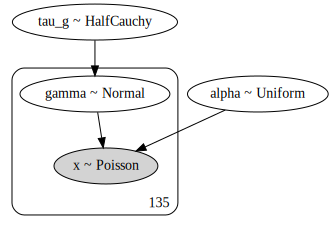

In [90]:
model_to_graphviz(model)

In [91]:
with model:
    trace = pm.sample(5000, n_init=10000, tune=1000, random_seed=seed, init='advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 88,423: 100%|██████████| 10000/10000 [00:03<00:00, 2719.38it/s]   
Finished [100%]: Average Loss = 88,012
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, gamma, tau_g]
Sampling 2 chains: 100%|██████████| 12000/12000 [06:47<00:00, 14.70draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [92]:
az.effective_sample_size(trace)

<xarray.Dataset>
Dimensions:      (alpha_dim_0: 1, gamma_dim_0: 135, tau_g_dim_0: 1)
Coordinates:
  * gamma_dim_0  (gamma_dim_0) int64 0 1 2 3 4 5 6 ... 129 130 131 132 133 134
  * tau_g_dim_0  (tau_g_dim_0) int64 0
  * alpha_dim_0  (alpha_dim_0) int64 0
Data variables:
    gamma        (gamma_dim_0) float64 564.0 2.295e+03 1.042e+03 ... 568.0 672.0
    tau_g        (tau_g_dim_0) float64 1.212e+04
    alpha        (alpha_dim_0) float64 450.0

In [ ]:
az.rhat(trace)

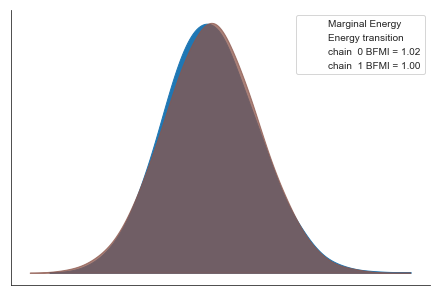

In [96]:
az.plot_energy(trace);

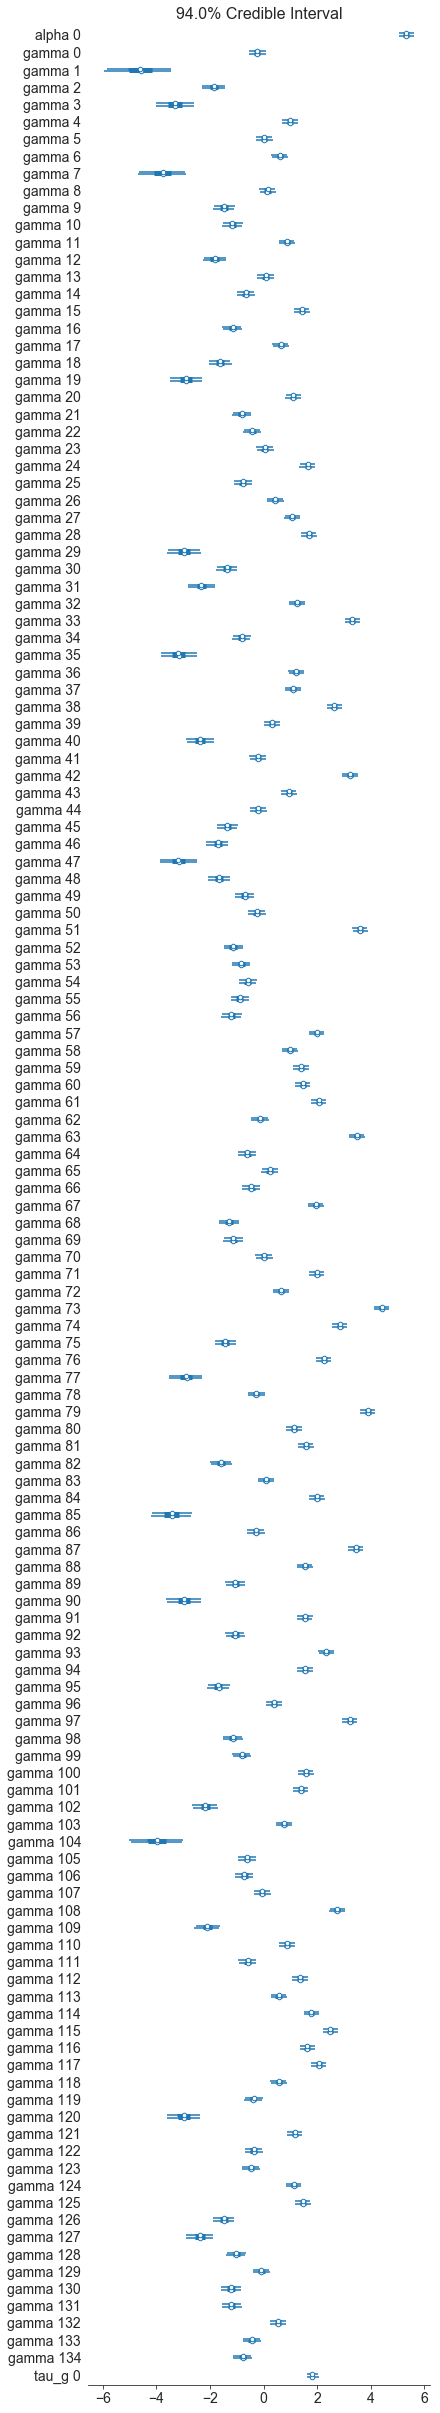

In [97]:
az.plot_forest(trace, credible_interval=0.95, r_hat=True);

In [ ]:
az.plot_trace(trace);

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


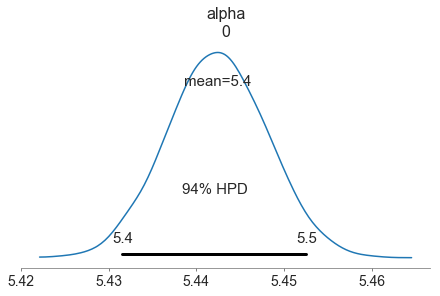

In [46]:
az.plot_posterior(trace, varnames=['gamma']);

In [47]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, 5000, random_seed=23)

100%|██████████| 5000/5000 [00:02<00:00, 1932.90it/s]


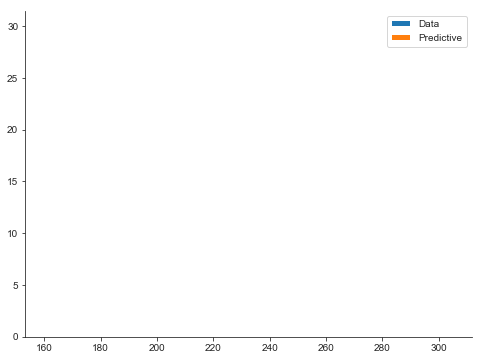

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(count_table['counts'].values, bins=30, density=True, histtype='step', lw=2, label='Data');
ax.hist(ppc_trace['x'], bins=30, density=True, histtype='step', lw=2, label='Predictive');
ax.legend(loc=1);